# Нейронная сеть для классификации грибов (по видам)

In [23]:
# Импортируем необходимые библиотеки
import os
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth

In [24]:
# Разрешаем загружать усеченные изображения
# чтобы исключить ошибку "Image File is truncated"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [26]:
# Найстроки отображения объектов
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

In [27]:
# Обучать будем на GPU
physical_devices = list_physical_devices('GPU')
print(f'Количество доступных GPU: {len(physical_devices)}')

if len(physical_devices) > 0:
    set_memory_growth(physical_devices[0], True)

Количество доступных GPU: 1


In [28]:
# TensorFlow константы
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 227
BATCH_SIZE = 64

## Загрузка и обработка данных

In [29]:
# Подключаем гугл диск с датасетом
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Путь к папке с 9 классами изображений
data_path = '/content/drive/MyDrive/ColabNotebooks/neuro_project/Mushrooms'

In [ ]:
# Разделим изображения в пропорции 75%/15%/10% и сохраним во временные папки
for subfolder in os.listdir(data_path):

    # Список всех файлов в текущей подпапке
    original_path = f'{data_path}/{subfolder}'
    original_data = os.listdir(original_path)

    # Количество образцов в каждой группе
    n_samples = len(original_data)
    train_samples = int(n_samples * 0.75)
    valid_samples = int(n_samples * 0.9)

    train_path = f'/content/drive/MyDrive/ColabNotebooks/neuro_project/temp/train/{subfolder}'
    valid_path = f'/content/drive/MyDrive/ColabNotebooks/neuro_project/temp/valid/{subfolder}'
    test_path = f'/content/drive/MyDrive/ColabNotebooks/neuro_project/temp/test/{subfolder}'

    # Новая подпапка классов для обучения
    os.chdir('/content/drive/MyDrive/ColabNotebooks/neuro_project/temp/train')
    os.mkdir(subfolder)

    # Тренировочные изображения
    for image in range(train_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{train_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)

    # Новая подпапка класса для валидации
    os.chdir('/content/drive/MyDrive/ColabNotebooks/neuro_project/temp/valid')
    os.mkdir(subfolder)

    # Изображения для валидации:
    for image in range(train_samples, valid_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{valid_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)

    # Новая подпапка класса для теста
    os.chdir('/content/drive/MyDrive/ColabNotebooks/neuro_project/temp/test')
    os.mkdir(subfolder)

    # Изображения для теста:
    for image in range(valid_samples, n_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{test_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)

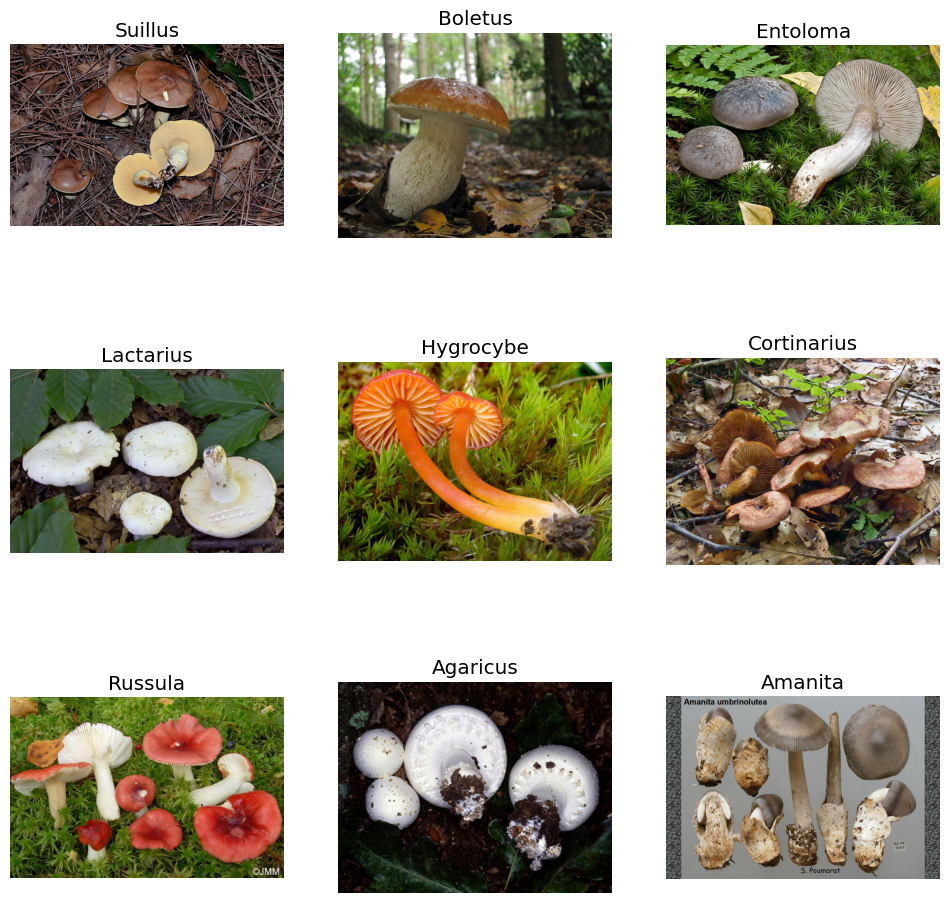

In [10]:
# Посмотрим на примеры каждого из классов
nrows = 3
ncols = 3

pos = 0

for subfolder in os.listdir(data_path):

    image_file = os.listdir(os.path.join(data_path, subfolder))[0]

    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(data_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

In [32]:
# Создадим тестовый, валидационный и тренировочный наборы данных
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/drive/MyDrive/ColabNotebooks/neuro_project/temp/train',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/drive/MyDrive/ColabNotebooks/neuro_project/temp/valid',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/drive/MyDrive/ColabNotebooks/neuro_project/temp/test',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

Found 3432 images belonging to 9 classes.
Found 667 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


## Создание модели

In [12]:
# Предварительно обученная модель классификации изображений EfficientNetB7 без финальных слоев
feature_model = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                     pooling='avg')

feature_model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 227, 227, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 227, 227, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Resc

In [13]:
# Создадим новую модель и добавим последний слой для классификации
new_model = tf.keras.models.Sequential(
    [
        feature_model,
        tf.keras.layers.Dense(9, activation='softmax')
    ]
)

In [14]:
# Сделать все слои исходной модели необучаемыми
new_model.layers[0].trainable = False

In [15]:
# Метрики и оптимизатор
new_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [16]:
# Проверим архитектуру новой модели
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 dense (Dense)               (None, 9)                 23049     
                                                                 
Total params: 64120736 (244.60 MB)
Trainable params: 23049 (90.04 KB)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [17]:
# Добавим сallbacks
# Остановим обучение если метрика не улучшается
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10,
                                              restore_best_weights=True)

# И будем снижать скорость обучения если метрика перестанет улучшаться
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)

In [18]:
# Обучим нашу модель
history = new_model.fit(train_generator,
                        validation_data=valid_generator,
                        epochs=50,
                        steps_per_epoch=79,
                        validation_steps=16,
                        verbose=2,
                        callbacks=[reduce_lr, early_stop],
                        use_multiprocessing=True,
                        workers=2)

Epoch 1/50
79/79 - 633s - loss: 1.1297 - accuracy: 0.6042 - val_loss: 0.8533 - val_accuracy: 0.7001 - lr: 0.0010 - 633s/epoch - 8s/step
Epoch 2/50
79/79 - 82s - loss: 0.7978 - accuracy: 0.7287 - val_loss: 0.7422 - val_accuracy: 0.7214 - lr: 0.0010 - 82s/epoch - 1s/step
Epoch 3/50
79/79 - 84s - loss: 0.6966 - accuracy: 0.7742 - val_loss: 0.6782 - val_accuracy: 0.7579 - lr: 0.0010 - 84s/epoch - 1s/step
Epoch 4/50
79/79 - 78s - loss: 0.6270 - accuracy: 0.7975 - val_loss: 0.6432 - val_accuracy: 0.7579 - lr: 0.0010 - 78s/epoch - 982ms/step
Epoch 5/50
79/79 - 79s - loss: 0.5845 - accuracy: 0.8081 - val_loss: 0.5914 - val_accuracy: 0.7974 - lr: 0.0010 - 79s/epoch - 1s/step
Epoch 6/50
79/79 - 80s - loss: 0.5356 - accuracy: 0.8271 - val_loss: 0.5783 - val_accuracy: 0.8075 - lr: 0.0010 - 80s/epoch - 1s/step
Epoch 7/50
79/79 - 79s - loss: 0.5082 - accuracy: 0.8393 - val_loss: 0.5573 - val_accuracy: 0.8085 - lr: 0.0010 - 79s/epoch - 1s/step
Epoch 8/50
79/79 - 85s - loss: 0.4837 - accuracy: 0.8492 

# Оценим результаты обучения




In [33]:
loss, accuracy = new_model.evaluate(test_generator,
                                    steps=11,
                                    verbose=2,
                                    use_multiprocessing=True,
                                    workers=2)
print(f'Производительность модели на тестовых изображениях:\nAccuracy = {accuracy}\nLoss = {loss}')

11/11 - 10s - loss: 0.5658 - accuracy: 0.8146 - 10s/epoch - 864ms/step
Производительность модели на тестовых изображениях:
Accuracy = 0.8146417737007141
Loss = 0.5658105611801147


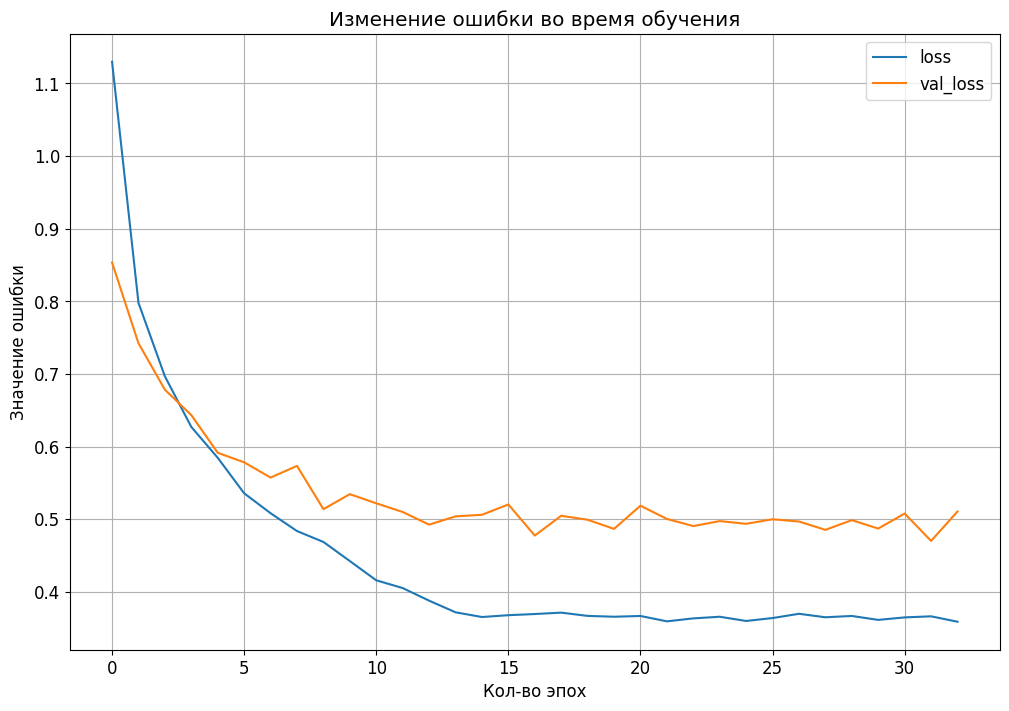

In [37]:
# Изменение ошибки во время обучения:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot(
    title='Изменение ошибки во время обучения',
    grid=True,
    xlabel='Кол-во эпох',
    ylabel='Значение ошибки'
    );

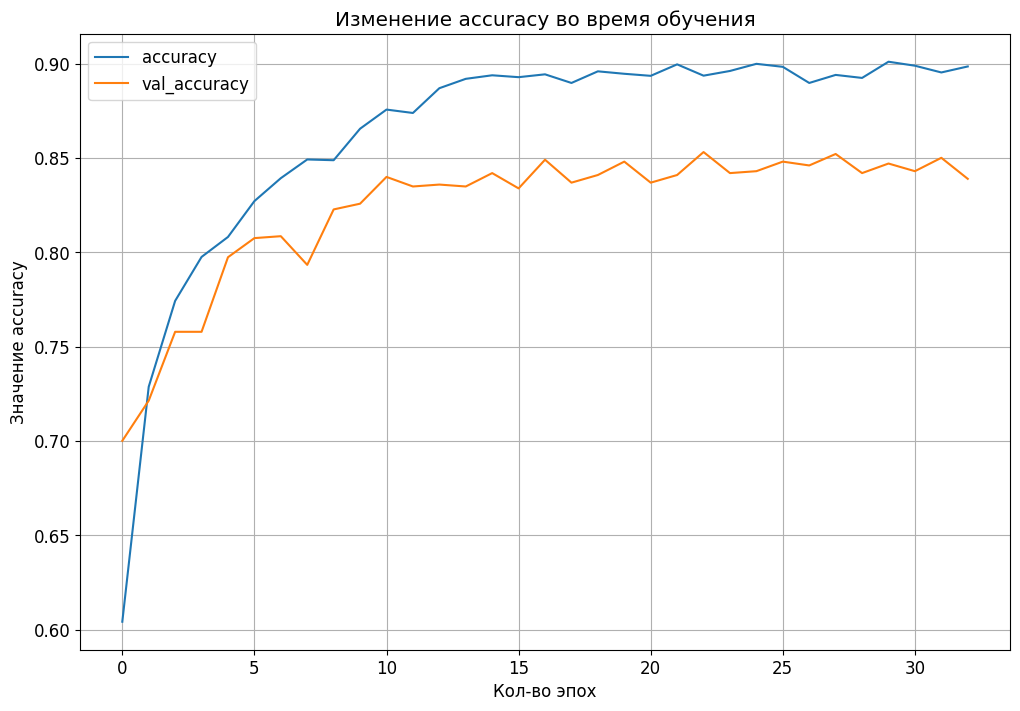

In [38]:
# Изменение accuracy во время обучения
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(
    title='Изменение accuracy во время обучения',
    grid=True,
    xlabel='Кол-во эпох',
    ylabel='Значение accuracy'
);

# Выводы
* Исходный датасет для обучения содержит около 4500 фотографий грибов, разбитых на 9 классов по признаку "тип гриба"
* Датасет был разделен на train, validation и tets выборки в пропорции 75%/15%/10%
* С помощью ImageDataGenerator на основе выборок train, validation и tets созданы наборы данных для обучения модели
* Для классификации взята предобученная модель EfficientNetB7 в которую мы добавили 1 финальный слой
* Лучшие показатели метрик Accuracy = 0.81 и Loss = 0.56

# Записываем модель в .pkl для использования на backend tg бота

In [39]:
import pickle

pickle.dump(new_model, open("model.pkl", "wb"))